# Analysis of Variance

In [1]:
import numpy as np
from scipy import stats
import pandas as p
import matplotlib.pyplot as plt
import seaborn as sns

# Objectives

- Understand the issues of multiple comparisons
- Compare and contrast $t$-tests with ANOVA
- Implement ANOVA in Python

# Preparing Some Data

> We will use the data from this [documentation on SciPy's `f_oneway()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) "on a shell measurement (the length of the anterior adductor muscle scar, standardized by dividing by length) in the mussel *Mytilus trossulus* from five locations: Tillamook, Oregon; Newport, Oregon; Petersburg, Alaska; Magadan, Russia; and Tvarminne, Finland, taken from a much larger data set"

<img alt="mytilus trossulus mussel shell" src="images/mytilus_trossulus_inside.jpg" width=50%/>

> Image from Walla Walla University: https://inverts.wallawalla.edu/Mollusca/Bivalvia/Mytiloida/Mytilidae/Mytilus_trossulus.html

In [2]:
# Data found from above URL
tillamook = [0.0571, 0.0813, 0.0831, 0.0976, 0.0817, 0.0859, 0.0735,
             0.0659, 0.0923, 0.0836]
newport = [0.0873, 0.0662, 0.0672, 0.0819, 0.0749, 0.0649, 0.0835,
           0.0725]
petersburg = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
magadan = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764,
           0.0689]
tvarminne = [0.0703, 0.1026, 0.0956, 0.0973, 0.1039, 0.1045]

# Nice DF for us
data = []
data += [('tillamook', v) for v in tillamook]
data += [('newport', v) for v in newport]
data += [('petersburg', v) for v in petersburg]
data += [('magadan', v) for v in magadan]
data += [('tvarminne', v) for v in tvarminne]

df = pd.DataFrame(data=data, columns=['area','shell_standardized'])
df.sample(8)
df

,area,shell_standardized
0,tillamook,0.0571
1,tillamook,0.0813
2,tillamook,0.0831
3,tillamook,0.0976
4,tillamook,0.0817
5,tillamook,0.0859
6,tillamook,0.0735
7,tillamook,0.0659
8,tillamook,0.0923
9,tillamook,0.0836


In [3]:
# Looking at the different groups
df.groupby('area').agg(['mean', 'std'])

shell_standardized          
                         mean       std
area                                   
magadan              0.078012  0.012945
newport              0.074800  0.008597
petersburg           0.103443  0.016209
tillamook            0.080200  0.011963
tvarminne            0.095700  0.012962

# Comparing Samples to Another

In the past lectures, we focused on 1-sample tests where we compare a sample with the population.

But sometimes we really want to compare two or more samples together. That's going to be our main focus today.

We'll start with the two sample $t$-test and then discuss its limitations.

## Two Sample $t$-Test

> Sometimes we want to do a hypothesis test to compare two samples to see if they're not significantly different from another (they come from the same overlying population).

We won't go into the details of performing a two sample $t$-test, but know that we must consider the means, samples' standard deviations, and number of observations for each sample to perform the test.

> **MATH**
> 
> Here is the formula for the two sample $t$-test:
> 
> $$ t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{s^2 \left( \frac{1}{n_1} + \frac{1}{n_2} \right)}}$$
>
> where $s^2$ is the pooled sample variance:
>
> $$ s^2 = \frac{\sum_{i=1}^{n_1} \left(x_i - \bar{x_1}\right)^2 + \sum_{j=1}^{n_2} \left(x_j - \bar{x_2}\right)^2 }{n_1 + n_2 - 2} $$

We can use SciPy's implementation using either the samples (`scipy.stat.ttest_ind()`) or the statistics of the samples (`scipy.stat.ttest_ind_from_stats()`). Here are their respective documentations:

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html

### Visualization of Two Samples

Let's isolate the two Oregon locations and observe what these two groups look like:

In [4]:
print('tillamook:')
df_tillamook = df[df['area'] == 'tillamook']
display(df_tillamook.describe())
print('\n----------------------\n')
print('newport:')
df_newport = df[df['area'] == 'newport']
display(df_newport.describe())

tillamook:


,shell_standardized
count,10.000000
mean,0.080200
std,0.011963
min,0.057100
25%,0.075450
50%,0.082400
75%,0.085325
max,0.097600



----------------------

newport:


,shell_standardized
count,8.000000
mean,0.074800
std,0.008597
min,0.064900
25%,0.066950
50%,0.073700
75%,0.082300
max,0.087300


/var/folders/9n/kzdbb24d6718p004k3bbjtr40000gn/T/ipykernel_19803/282413098.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(
/var/folders/9n/kzdbb24d6718p004k3bbjtr40000gn/T/ipykernel_19803/282413098.py:11: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.swarmplot(


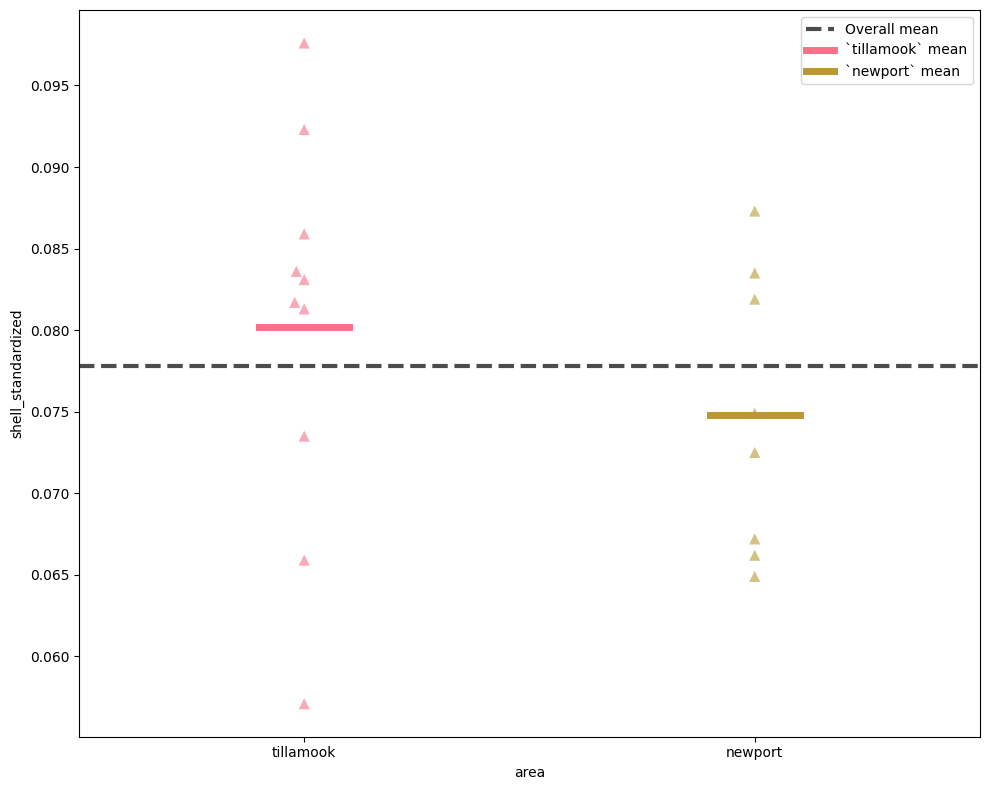

In [5]:
f, ax = plt.subplots(figsize=(10, 8))

# Use specific set of colors
colors = sns.color_palette('husl')

# Select only two areas
selection_mask = (df['area'] == 'tillamook') | (df['area'] == 'newport')
data_subset = df[selection_mask]

# Data Points
ax = sns.swarmplot(
    data=data_subset,
    x="area",
    y="shell_standardized",
    ax=ax,
    alpha=0.6, 
    marker='^',
    size=8,
    palette=colors
)

ax.axhline(
    data_subset['shell_standardized'].mean(), label='Overall mean',
    lw=3, ls='--', color='black', alpha=0.7
)

# Look at each specifc group (by area)
areas = data_subset['area'].unique()
for i, area in enumerate(areas):
    mean = df[df['area']==area]['shell_standardized'].mean()
    # Make these lines short and near each group
    xmin = 1/len(areas) * i + 0.2
    xmax = xmin + 0.1
    ax.axhline(
        mean, xmin=xmin, xmax=xmax, label=f'`{area}` mean',
        lw=5, ls='-', color=colors[i]
    ) 
    
ax.legend()
plt.tight_layout();

KeyError: 'shell_standaradized'

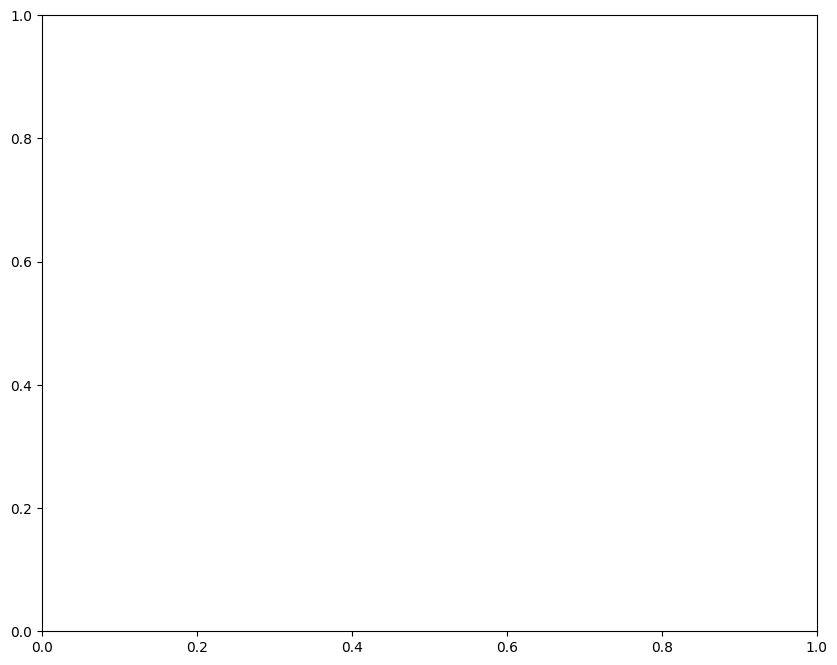

In [7]:
f, ax = plt.subplots(figsize=(10,8))
ax.hist(tilla['shell_standaradized'], bins = 10)
a

### Performing the Two-Sample $t$-Test (SciPy)

Before getting our test statistic and p-value, we should define our significance level $\alpha$. In this case we'll set to a conservative $\alpha=0.01$

In [9]:
# Peform the two-sample t-test (are the samples different?)
stats.ttest_ind(tillamook, newport, equal_var=False)

Ttest_indResult(statistic=1.112729859319956, pvalue=0.2823978786684557)

And we see that we don't have a significant result between these two (don't reject $H_0$)

## But I Want It All!

> We could compare multiple times with $t$-tests. 
> 
> What's the worst that can happen...? ***foreshadowing***

### Visualization of More Samples

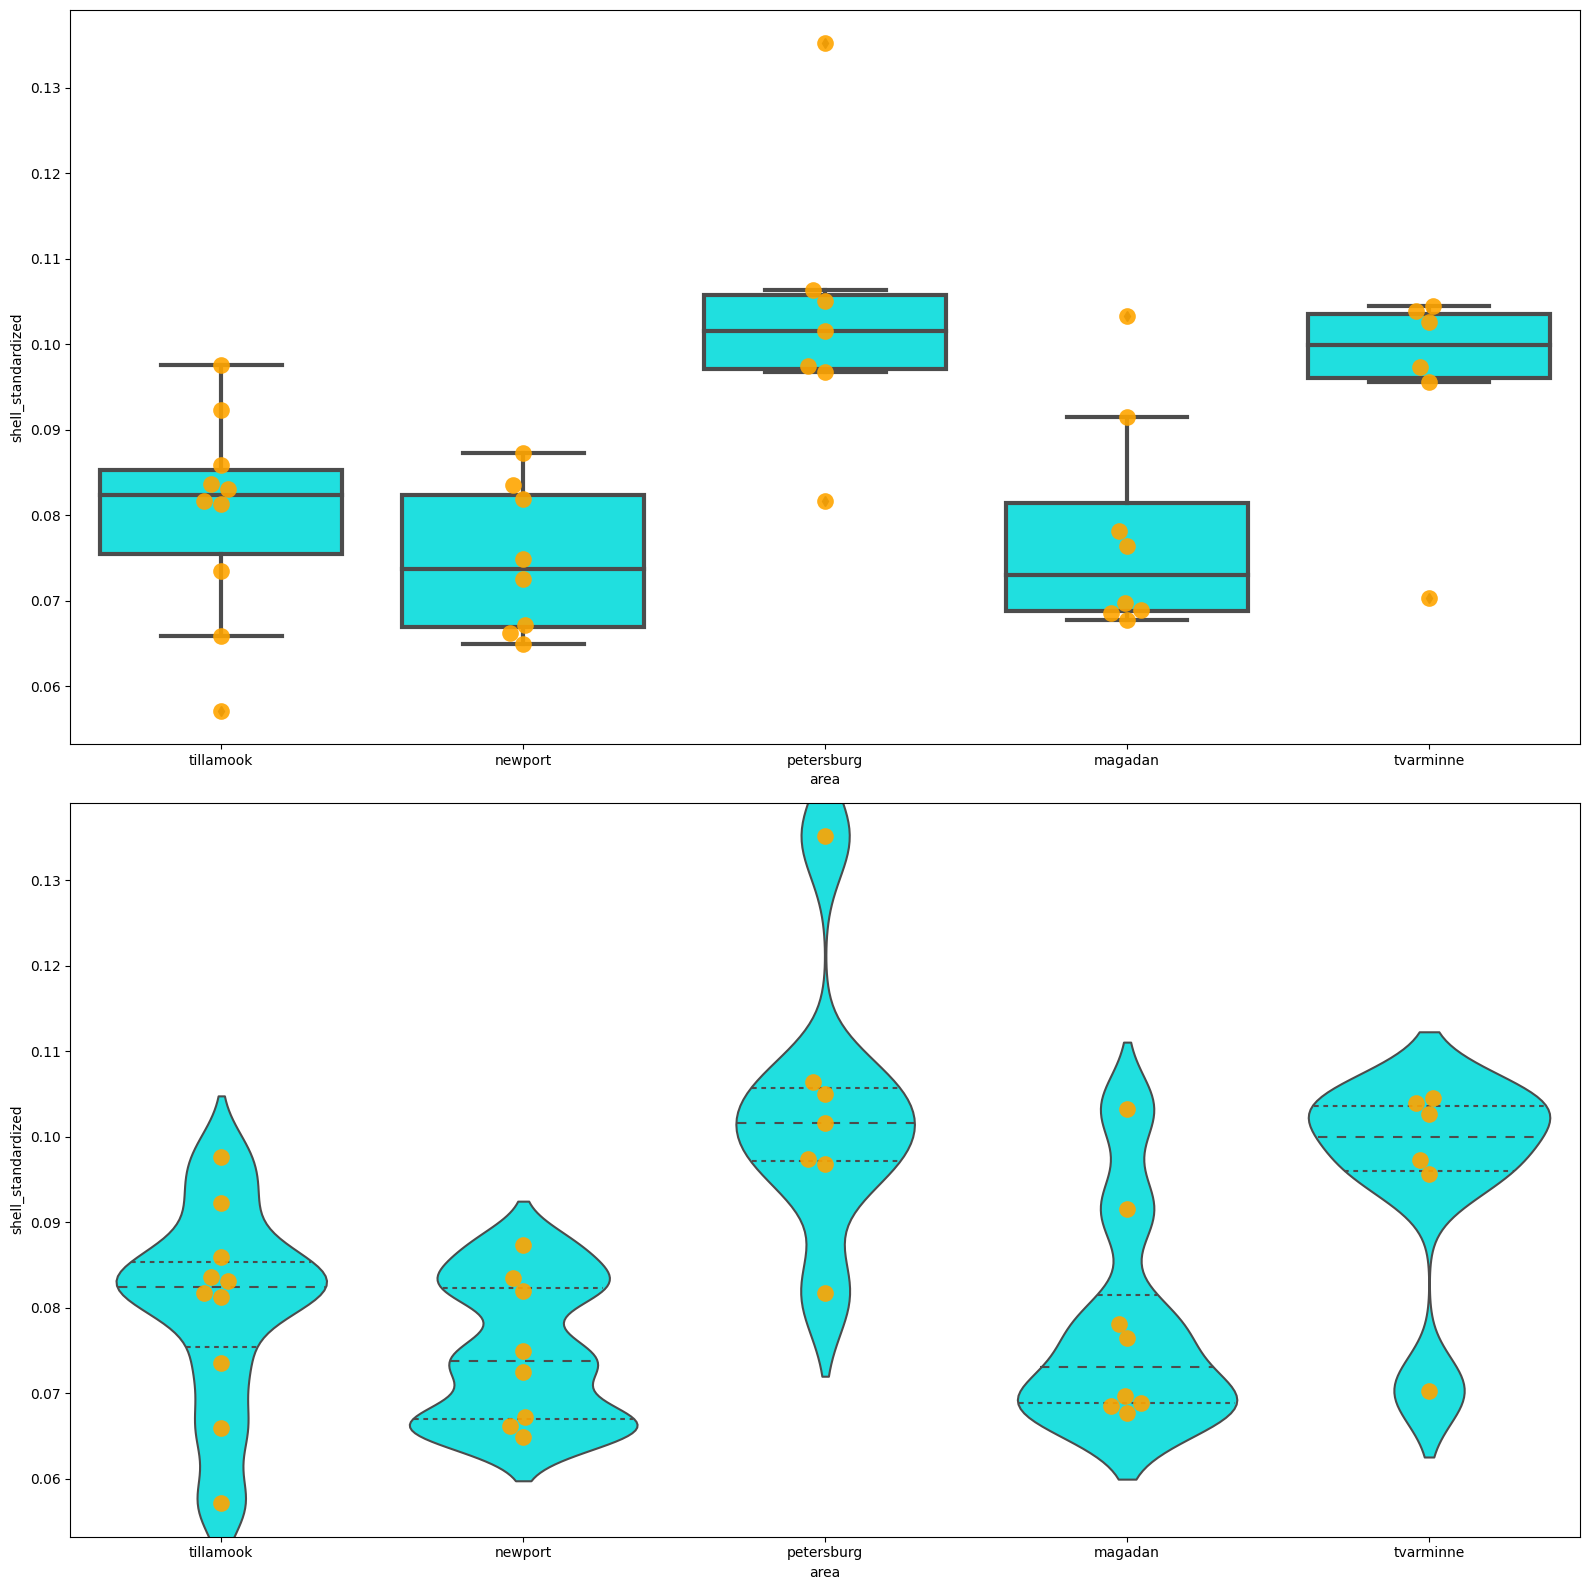

In [10]:
fig, (ax0,ax1) = plt.subplots(nrows=2, figsize=(16, 16))

sns.boxplot(
    x="area",
    y="shell_standardized",
    data=df,
    ax=ax0,
    color='aqua', 
    linewidth=3
)

sns.swarmplot(
    x="area",
    y="shell_standardized",
    data=df,
    ax=ax0,
    color='orange', 
    alpha=0.9, 
    size=12
)



sns.violinplot(
    y="shell_standardized", 
    x="area", 
    data=df, 
    ax=ax1,
    color='aqua',
    inner="quartile",  
    bw=.3              
)

sns.swarmplot(
    x="area",
    y="shell_standardized",
    data=df,
    ax=ax1,
    color='orange', 
    alpha=0.9, 
    size=12
)

plt.tight_layout();

### Performing Multiple $t$-tests ← DO NOT DO!

> ☠️ ***WARNING*** ☠️
>
> You shouldn't perform multiple $t$-tests! We do this for illustrative purposes!
>
> We are trained data science stunt-statisticians; do not try this at home, workplace, or in front of stakeholders

In [11]:
# Extra tools to make this stunt easier to do
from itertools import combinations
groups = {'tillamook':tillamook, 'newport':newport, 'magadan':magadan,
          'tvarminne':tvarminne, 'petersburg':petersburg}

# Our signifance level
alpha = 0.01

# Perform two sample t-tests on all combination pairs
for group_a, group_b in combinations(groups,2):
    # Make it easy for us to identify
    print(f't-test on {group_a} & {group_b}')
    
    # Easy reference of samples
    X_a = groups.get(group_a)
    X_b = groups.get(group_b)
    # Perform our test on pair
    t, p = stats.ttest_ind(X_a, X_b)
    
    # Print our values
    print(f'\t t:{t:.2f}, p:{p:.3f}')
    if p < alpha:
        print(f'\t***** SIGNIFICANT AT {alpha} LEVEL****')
    print('\n')

t-test on tillamook & newport
	 t:1.07, p:0.300


t-test on tillamook & magadan
	 t:0.37, p:0.715


t-test on tillamook & tvarminne
	 t:-2.43, p:0.029


t-test on tillamook & petersburg
	 t:-3.41, p:0.004
	***** SIGNIFICANT AT 0.01 LEVEL****


t-test on newport & magadan
	 t:-0.58, p:0.568


t-test on newport & tvarminne
	 t:-3.64, p:0.003
	***** SIGNIFICANT AT 0.01 LEVEL****


t-test on newport & petersburg
	 t:-4.36, p:0.001
	***** SIGNIFICANT AT 0.01 LEVEL****


t-test on magadan & tvarminne
	 t:-2.53, p:0.026


t-test on magadan & petersburg
	 t:-3.38, p:0.005
	***** SIGNIFICANT AT 0.01 LEVEL****


t-test on tvarminne & petersburg
	 t:-0.94, p:0.368




So it looks like **newport and tvarminne** are significantly different from one another and every group except tvarminne is significantly different from **petersburg**! So there is a difference, right?

Turns out there are some issues with the little stunt we pulled 🤕

### Issues?

There are some concerns in what we just did:

- If we test _every_ combination, this can be a lot of $t$-tests
    + You would need $\frac{n(n-1)}{2}$ $t$-tests
- If there really isn't a difference, we're more likely to have false positives (type 1 errors)
    + If our original probability of making a Type 1 error was $\alpha$ and we do $n$ tests, then the probability of getting a Type 1 error would grow to $1-(1-\alpha)^n$. In our case of $10$ tests & $\alpha=0.01$, we have $1-(1-0.01)^{10}$ or $10\%$ chance of making an error!

![](https://imgs.xkcd.com/comics/significant.png)

# ANOVA - Analysis of Variance

One solution to the multiple comparison problem is to perform a statistical test that looks at _all_ the samples together to determine if they are statistically different. 

One such test is the **analysis of variance** or **ANOVA test** (also called the **$F$ one-way test**).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/V838_Mon_HST.jpg/480px-V838_Mon_HST.jpg)
<!-- 
https://commons.wikimedia.org/wiki/File:V838_Mon_HST.jpg
The Hubble material you see on this page is copyright-free. Material credited to STScI on this site was created, authored, and/or prepared for NASA under Contract NAS5-26555.
-->

> ANOVA: an acronym, not a stellar object. Well, it is pretty stellar but not in the space sense.

## The $F$-Statistic

At the heart of ANOVA is the **$F$-statistic** **$F$-ratio**.

![](images/heart_of_anova.png)

We won't dig into the math, since honestly we don't need to do it by hand generally. But know the $F$-statistic is trying to capture the variance _between groups_ and _within groups_. This is done by comparing the individuals with the group means and the overall mean.

The $F$-distribution therefore has **two** degrees-of-freedom parameters, and can in fact be thought of as a ratio of $\chi^2$ distributions.

For more on how the $F$-distribution is relevant to ANOVA, see [this post](https://blog.minitab.com/en/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test).

Just like with $t$ and $z$ tests, we calculate a test statistic, then compare it to a critical value associated with a probability distribution. In this case, that distribution is the [$F$-distribution](https://en.wikipedia.org/wiki/F-distribution).

Let's draw some $F$ curves:

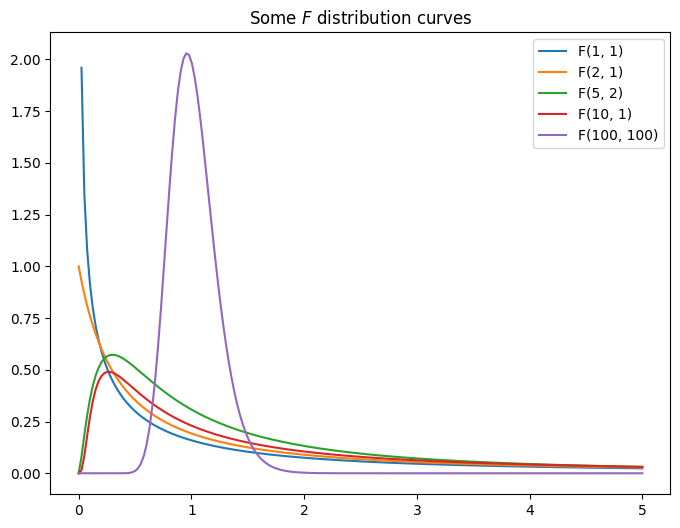

In [14]:
f_11 = stats.f(dfn=1, dfd=1)
f_21 = stats.f(dfn=2, dfd=1)
f_52 = stats.f(dfn=5, dfd=2)
f_101 = stats.f(dfn=10, dfd=1)
f_100100 = stats.f(dfn=100, dfd=100)
x = np.linspace(0, 5, 200)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, f_11.pdf(x), label='F(1, 1)')
ax.plot(x, f_21.pdf(x), label='F(2, 1)')
ax.plot(x, f_52.pdf(x), label='F(5, 2)')
ax.plot(x, f_101.pdf(x), label='F(10, 1)')
ax.plot(x, f_100100.pdf(x), label='F(100, 100)')
ax.set_title('Some $F$ distribution curves')

ax.legend();

### Visualizing the Data and $F$-Statistic

/var/folders/9n/kzdbb24d6718p004k3bbjtr40000gn/T/ipykernel_19803/3921945113.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(
/var/folders/9n/kzdbb24d6718p004k3bbjtr40000gn/T/ipykernel_19803/3921945113.py:7: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.swarmplot(


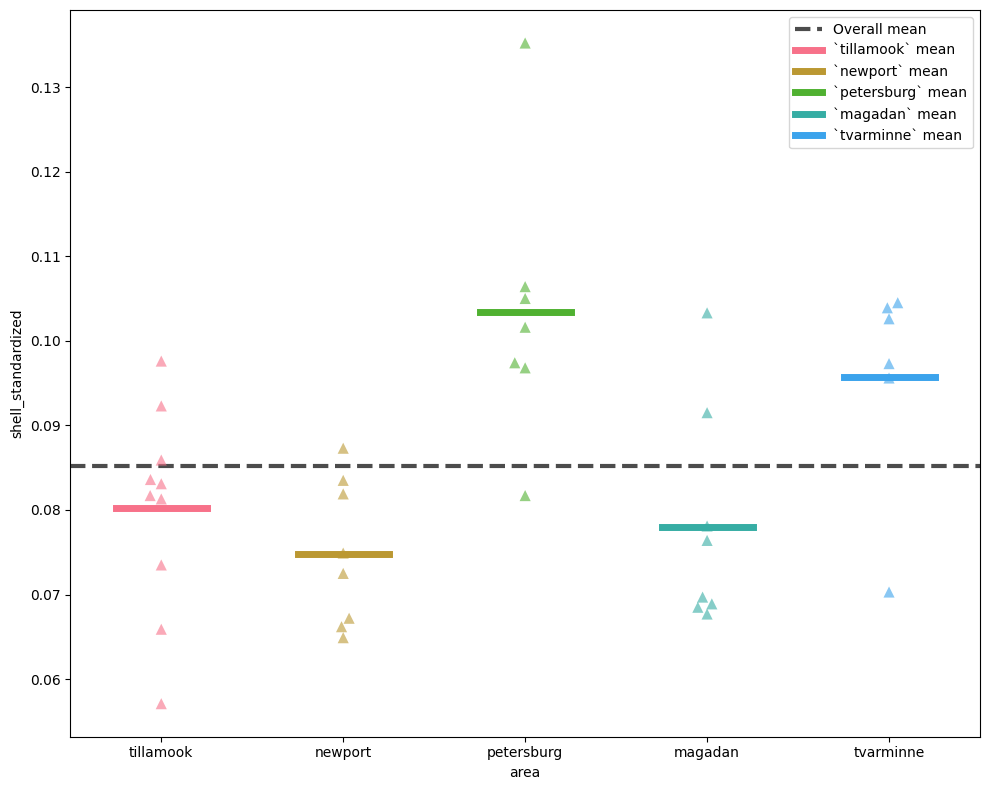

In [15]:
f, ax = plt.subplots(figsize=(10,8))

# Use specific set of colors
colors = sns.color_palette('husl')

# Data Points
ax = sns.swarmplot(
    data=df,
    x="area",
    y="shell_standardized",
    ax=ax,
    alpha=0.6, 
    marker='^',
    size=8,
    palette=colors
)

# Overall mean line
ax.axhline(
    df['shell_standardized'].mean(), label='Overall mean',
    lw=3, ls='--', color='black', alpha=0.7
)

# Look at each specifc group (by area)
areas = df['area'].unique()
for i,area in enumerate(areas):
    mean = df[df['area']==area]['shell_standardized'].mean()
    # Make these lines short and near each group
    xmin = 1/len(areas) * i + 0.05
    xmax = xmin + 0.1
    ax.axhline(
        mean, xmin=xmin, xmax=xmax, label=f'`{area}` mean',
        lw=5, ls='-', color=colors[i]
    ) 
    
ax.legend()
plt.tight_layout();

#### More Details on Variance Between and Within Groups

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image046.png" width="500">

### Between Group Variability

Measures how much the means of each group vary from the mean of the overall population



<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image0171.png" width="500">
    

### Within Group Variability

Refers to variations caused by differences within individual groups.  

Consider the given distributions of three samples below. As the spread (variability) of each sample is increased, their distributions overlap and they become part of a big population.
<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image031.png" width="500">

Now consider another distribution of the same three samples but with less variability. Although the means of samples are similar to the samples in the above image, they seem to belong to different populations.

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image033.png" width="500">


## Performing One-Way ANOVA

We saw from above that it probably isn't immediately obvious if these groups are in fact different. We still do our normal steps for hypothesis steps but use the [`scipy.stats.f_oneway()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) to get our test statistic ($F$-statistic)  and p-value.

- $H_0$ : $\mu_{tillamook} = \mu_{newport} = \mu_{magadan} = \mu_{tvarminne} = \mu_{petersburg}$
- $H_a$ : $H_0$ is not true

In [16]:
# Define our alpha significance level
alpha = 0.01

In [17]:
groups = {'tillamook':tillamook, 'newport':newport, 'magadan':magadan,
          'tvarminne':tvarminne, 'petersburg':petersburg}

# Note I'm simply unpacking the iterator instead of typing each out
result = None
f_stat, p = result
# Printing out the result just to show what it looks like
result

TypeError: cannot unpack non-iterable NoneType object

In [18]:
conclusion = 'significant' if p < alpha else 'not significant'

print(f'''
The difference between the different groups was {conclusion} for a significance
level of {alpha}.
''')


The difference between the different groups was not significant for a significance
level of 0.01.



### Note: Excluding One Group

> Note that we could have an _insignificant_ result if we removed "petersburg" from the group

In [19]:
groups = {'tillamook':tillamook, 'newport':newport, 'magadan':magadan, 'tvarminne':tvarminne}

# Note I'm simply unpacking the iterator instead of typing each out
result = stats.f_oneway(*groups.values())
f_stat, p = result

print(result)

conclusion = 'significant' if p < alpha else 'not significant'

print(f'''
The difference between the different groups was {conclusion} for a significance
level of {alpha}.
''')

F_onewayResult(statistic=4.10752164748393, pvalue=0.015554878284932846)

The difference between the different groups was not significant for a significance
level of 0.01.



## ANOVA is an Omnibus Test

Remember that ANOVA only tells us _if_ there is significant difference in the groups, not _which_ group is significant.

> **NOTE** 
>
>If we follow up with trying to find which groups are significantly different from each other, you have to consider *post-hoc* tests. You should avoid doing _multiple_ tests.
>
> More information can be found in a [Level Up section](#Level-Up---Follow-Up-with-Post-Hoc-Tests) below.

# Exercise: Two-Sample T-Test

A sample of 20 data science students from Dr. Venkman's Data Science 101 lecture course showed an average of 80.5 points on the last test, with a standard deviation of 9.9 points. Meanwhile, a sample of 28 students from Dr. Yates's Data Science 101 lecture course showed an average of 86.3 points on the same test, with a standard deviation of 11.2 points. Are Dr. Yates's students performing (significantly) better than Dr. Venkman's? Assume the two student populations have equal variances and use an alpha level of 0.05.

Bonus:
- How can we calculate the pooled variance for these samples?
- How can we calculate the t-statistic by hand?

H_0 : Dr. Yate's score on average are not higher than DR. Venkman's

H_A : Dr. Yate's class have significantly higher test scores than Dr. Venkman's

In [30]:
stats.ttest_ind_from_stats(86.3, 11.2, 28, 80.5, 9.9, 20)
# Dr. Yates

Ttest_indResult(statistic=1.8545524566497287, pvalue=0.07007690546143298)

In [ ]:
stats.ttest_ind_from_stats(80.5, 9.9, 20, 86.5, 9.9, 20)

In [31]:
statistic, pvalue = stats.ttest_ind_from_stats(86.3, 11.2, 28, 80.5, 9.9, 20)
pvalue / 2

0.03503845273071649

In [37]:
mean1 = 80.5
std1 = 9.9
nobs1 = 20
mean2 = 86.3
std2 = 11.2
nobs2 = 28
sum_x1_diffs_sq = (nobs1-1) * std1**2
sum_x2_diffs_sq = (nobs2-1) * std2**2
var_pool = (sum_x1_diffs_sq + sum_x2_diffs_sq) / (nobs1+nobs2-2)
t_stat = (mean2 - mean1) / np.sqrt(var_pool * (1/nobs1 + 1/nobs2))
print(var_pool)
print(t_stat)

114.11021739130435
1.8545524566497287


In [39]:
1-stats.t.cdf(t_stat, df=46)

0.035038452730716485

<details>
    <summary>Answer</summary>
<code>stats.ttest_ind_from_stats(mean1=80.5,
                          std1=9.9,
                          nobs1=20,
                          mean2=86.3,
                          std2=11.2,
                          nobs2=28)</code>
    </details>

<details>
    <summary>Bonus Answer</summary>
<code>mean1 = 80.5
std1 = 9.9
nobs1 = 20
mean2 = 86.3
std2 = 11.2
nobs2 = 28
sum_x1_diffs_sq = (nobs1-1) * std1**2
sum_x2_diffs_sq = (nobs2-1) * std2**2
var_pool = (sum_x1_diffs_sq + sum_x2_diffs_sq) / (nobs1+nobs2-2)
t_stat = (mean1 - mean2) / np.sqrt(var_pool * (1/nobs1 + 1/nobs2))
print(var_pool)
print(t_stat)</code>
    </details>

# Level Up - `statsmodels`

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

> The OLS method from `statsmodels` gives an ANOVA table

In [ ]:
anova_season = ols('shell_standardized ~ C(area)', data=df).fit()
anova_season.summary()

# Level Up - Follow-Up with Post-Hoc Tests

Just because we have rejected the null hypothesis, it doesn't mean we have conclusively shown which group is significantly different from which - remember, the alternative hypothesis says simply that the null hypothesis is not true.

We need to conduct post-hoc tests for multiple comparisons to find out which groups are different. The most prominent post-hoc tests are:
- LSD (Least significant difference)
    - $t\sqrt \frac{MSE}{n^2}$
- Tukey's HSD 
    - $q\sqrt \frac{MSE}{n}$
    
https://www.statisticshowto.com/studentized-range-distribution/#qtable
    
After calculating a value for LSD or HSD, we compare each pair wise mean difference with the LSD or HSD difference. If the pairwise mean difference exceeds the LSD/HSD, then they are significantly different.

In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(df['shell_standardized'], df['area'], alpha=0.5))

    Multiple Comparison of Means - Tukey HSD, FWER=0.50     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
   magadan    newport  -0.0032 0.9858 -0.0134  0.0069  False
   magadan petersburg   0.0254 0.0037  0.0149  0.0359   True
   magadan  tillamook   0.0022  0.996 -0.0074  0.0118  False
   magadan  tvarminne   0.0177 0.0929  0.0067  0.0287   True
   newport petersburg   0.0286 0.0009  0.0181  0.0392   True
   newport  tillamook   0.0054 0.8935 -0.0042   0.015  False
   newport  tvarminne   0.0209 0.0317  0.0099  0.0319   True
petersburg  tillamook  -0.0232 0.0057 -0.0333 -0.0132   True
petersburg  tvarminne  -0.0077 0.8028  -0.019  0.0036  False
 tillamook  tvarminne   0.0155 0.1447   0.005   0.026   True
------------------------------------------------------------


In [26]:
tk_hsd = pairwise_tukeyhsd(df['shell_standardized'], df['area'])

In [27]:
tk_hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
magadan,newport,-0.0032,0.9858,-0.0213,0.0149,False
magadan,petersburg,0.0254,0.0037,0.0067,0.0442,True
magadan,tillamook,0.0022,0.996,-0.015,0.0194,False
magadan,tvarminne,0.0177,0.0929,-0.0019,0.0373,False
newport,petersburg,0.0286,0.0009,0.0099,0.0474,True
newport,tillamook,0.0054,0.8935,-0.0118,0.0226,False
newport,tvarminne,0.0209,0.0317,0.0013,0.0405,True
petersburg,tillamook,-0.0232,0.0057,-0.0411,-0.0054,True
petersburg,tvarminne,-0.0077,0.8028,-0.0279,0.0124,False
tillamook,tvarminne,0.0155,0.1447,-0.0032,0.0342,False


# Level Up - Two-Way ANOVA

Returning to the example at the very beginning of the lesson, say 
we found out, using one-way ANOVA, that the season was impactful on the mood of different people. What if the season was to affect different groups of people differently?  Maybe older people were affected more by the seasons than younger people.

Moreover, how can we be sure as to which factor(s) is affecting the mood more? Maybe the age group is a more dominant factor responsible for a person's mood than the season.

For such cases, when the outcome or dependent variable is affected by two independent variables/factors we use a slightly modified technique called two-way ANOVA.